In [1]:
from os import listdir
from os.path import isfile, join

def collect_filenames(dir):
    return [join(dir, f) for f in listdir(dir) if isfile(join(dir, f))]

txt_filenames = collect_filenames("./corpus_base_text_format")

## Data Preprocessing

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import words, stopwords
import math

class VOICE_Tokenizer:
    english_word_set = set(words.words())
    stop_word_set = set(stopwords.words('english'))
    
    def __init__(self, chunk_size = 40, remove_incomplete = True, filter_non_english = False, remove_stop_words = True):
        self.chunk_size = chunk_size
        self.remove_incomplete = remove_incomplete
        self.filter_non_english = filter_non_english
        self.remove_stop_words = remove_stop_words

    def is_valid_token(self, token):
        if('[' in token or ']' in token or '@' in token or token == ''):
            return False
        all_x = True
        for i in range(len(token)):
            if(token[i] is not 'x'): all_x = False
        return not all_x

    def is_english_word(self, token):
        return token in english_word_set
        
    def tokenize_txt_file_in_chunks(self, filename):
        file = open(filename, 'r', encoding='utf8')
        lines = file.readlines()
        token_chunks = []
        for i in range(math.ceil(len(lines) / self.chunk_size)):
            chunk = []
            for line in lines[i * self.chunk_size : max(len(lines), (i+1) * self.chunk_size)]:
                tokens = line.split(':')[2][2:-1].split(' ')
                for token in tokens:
                    if(self.is_valid_token(token)):
                        if(self.remove_incomplete and ('-' == token[-1] or '-' == token[0])):
                            chunk.append('INCOMPLETE')
                        elif(self.filter_non_english and not self.is_english_word(token)):
                            chunk.append('NON_ENGLISH')
                        else:
                            chunk.append(token.lower())

                    else:
                        continue
            if(self.remove_stop_words):
                token_chunks.append([w for w in chunk if not w in self.stop_word_set])
            else:
                token_chunks.append(chunk)
        return token_chunks

    def tokenize_txt_files_in_chunks(self, files):
        token_chunks_grouped_by_category = {}
        for file in files:
            token_chunks = self.tokenize_txt_file_in_chunks(file)
            category = file[28:31]
            if(category in token_chunks_grouped_by_category):
                if(len(token_chunks_grouped_by_category[category]) == 0): print(category)
                token_chunks_grouped_by_category[category] = token_chunks_grouped_by_category[category] + token_chunks
            else:
                token_chunks_grouped_by_category[category] = token_chunks
        return token_chunks_grouped_by_category, token_chunks_grouped_by_category.keys()

VT = VOICE_Tokenizer()
token_chunks_grouped_by_category, categories = VT.tokenize_txt_files_in_chunks(txt_filenames)

## Word Frequency Matrix and Most Frequent Words

In [3]:
import heapq

def calc_most_freq_tokens(n=500):
    word_freq = {}
    for cat in categories:
        for chunk in token_chunks_grouped_by_category[cat]:
            for token in chunk:
                if(token in word_freq):
                    word_freq[token] += 1
                else:
                    word_freq[token] = 1

    most_freq = heapq.nlargest(n, word_freq, key=word_freq.get)
    return word_freq, most_freq

word_freq, most_freq = calc_most_freq_tokens()

## Bag of Words Matrix
Using most frequent words.

In [4]:
import pandas as pd

def create_bag_of_words():
    chunk_vectors = []
    for i, cat in enumerate(categories):
        for chunk in token_chunks_grouped_by_category[cat]:
            chunk_vec = []
            for token in most_freq:
                if(token in chunk):
                    chunk_vec.append(1)
                else:
                    chunk_vec.append(0)
            chunk_vec.append(i)
            chunk_vectors.append(chunk_vec)
    
    return pd.DataFrame(chunk_vectors, columns=most_freq + ['CLASS'])

bag_of_words_df = create_bag_of_words()
bag_of_words_df

,er,yeah,mhm,INCOMPLETE,okay,erm,hh,like,know,yah,...,either,tried,r,approach,packaging,eighty,g,lego,sell,CLASS
0,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,1,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,1,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,1,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,1,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,1,1,0,1,1,1,0,1,1,0,...,0,0,0,1,0,0,0,0,1,9
2705,1,0,0,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,9
2706,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,1,1,0,0,9
2707,1,1,1,1,1,1,1,1,1,0,...,0,1,0,1,0,1,0,0,0,9


## Word Count Matrix
And some document and classification collection.

In [5]:
docs = []
classifications = []
for cat in categories:
    docs = docs + token_chunks_grouped_by_category[cat]
    classifications = classifications + [cat] * len(token_chunks_grouped_by_category[cat])
    
docs_as_sentences = []
for doc in docs:
    sentence = ""
    for word in doc:
        sentence += word + " "
    docs_as_sentences.append(sentence[:-1])

def create_word_count_df(docs):
    word_counts = []
    for doc in docs:
        doc_word_count = {}
        for word in doc:
            if word in doc_word_count:
                doc_word_count[word] += 1
            else:
                doc_word_count[word] = 0
        word_counts.append(doc_word_count)
    df = pd.DataFrame(word_counts).fillna(0)
    return df

word_count_df = create_word_count_df(docs)
word_count_df

,prego,eine,lasagne,la,contessa,gemuese,gerne,er,al,forno,...,hydroelectricities,outcry,insulated,exported,neighbors',affordable,bloomberg,protectionism,downstream,officials'
0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,257.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,253.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,240.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,235.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,223.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## TF-IDF Matrix
Full vocabulary of corpus.

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(word_count_df.values)
sklearn_tfidf = tfidf_transformer.transform(word_count_df.values).toarray()
sklearn_tfidf_df = pd.DataFrame(sklearn_tfidf, columns=word_count_df.columns)
sklearn_tfidf_df

,prego,eine,lasagne,la,contessa,gemuese,gerne,er,al,forno,...,hydroelectricities,outcry,insulated,exported,neighbors',affordable,bloomberg,protectionism,downstream,officials'
0,0.0,0.0,0.056485,0.009976,0.018062,0.0,0.0,0.581603,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.014421,0.000000,0.000000,0.0,0.0,0.584719,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.015304,0.000000,0.000000,0.0,0.0,0.588622,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.016005,0.000000,0.000000,0.0,0.0,0.602746,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.016726,0.000000,0.000000,0.0,0.0,0.597744,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.659237,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2705,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.510891,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2706,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.595961,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013238,0.0
2707,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.581930,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022987,0.0


## Train Test Split - Word Count

In [7]:
from sklearn.model_selection import train_test_split

wc_X = word_count_df.values
y = classifications

wc_X_train, wc_X_test, wc_y_train, wc_y_test = train_test_split(wc_X, y, random_state=3)

## Train Test Split - TF-IDF

In [8]:
tfidf_X = sklearn_tfidf_df.values

tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidf_X, y, random_state=3)

## Metrics Function

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

def calc_metrics(y, hyp, categories):
    sorted_categories = sorted(list(categories))
    conf_matrix = pd.DataFrame(confusion_matrix(y, hyp), columns=sorted_categories, index=sorted_categories)
    print(classification_report(y, hyp, digits=3))
    return conf_matrix

## Classifier Fit and Predict Function

In [10]:
def fit_classifier_and_predict(X_train, X_test, y_train, y_test, clf):
    clf = clf.fit(X_train, y_train)
    hyp_train = clf.predict(X_train)
    hyp_test = clf.predict(X_test)
    return hyp_train, hyp_test

## Multinomial Naive Bayes using Word Counts

In [11]:
from sklearn.naive_bayes import MultinomialNB

nb_y_train_hyp, nb_y_test_hyp = fit_classifier_and_predict(wc_X_train, wc_X_test, wc_y_train, wc_y_test, MultinomialNB())
calc_metrics(wc_y_train, nb_y_train_hyp, categories)

              precision    recall  f1-score   support

         con      0.936     0.925     0.931       456
         int      0.924     0.948     0.936       116
         mtg      0.960     0.888     0.922       569
         pan      0.882     0.909     0.896        33
         prc      1.000     1.000     1.000         7
         qas      1.000     0.591     0.743        22
         sed      1.000     0.966     0.983        88
         sve      0.977     0.956     0.966        45
         wgd      0.820     0.905     0.860       388
         wsd      0.926     0.977     0.951       307

    accuracy                          0.919      2031
   macro avg      0.943     0.906     0.919      2031
weighted avg      0.922     0.919     0.919      2031



,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,422,5,12,0,0,0,0,0,14,3
int,3,110,1,0,0,0,0,0,2,0
mtg,10,0,505,0,0,0,0,1,51,2
pan,0,0,1,30,0,0,0,0,2,0
prc,0,0,0,0,7,0,0,0,0,0
qas,0,1,0,4,0,13,0,0,4,0
sed,1,0,1,0,0,0,85,0,1,0
sve,0,0,2,0,0,0,0,43,0,0
wgd,13,3,2,0,0,0,0,0,351,19
wsd,2,0,2,0,0,0,0,0,3,300


In [12]:
calc_metrics(wc_y_test, nb_y_test_hyp, categories)

              precision    recall  f1-score   support

         con      0.932     0.919     0.926       149
         int      0.967     0.853     0.906        34
         mtg      0.949     0.913     0.931       206
         pan      0.833     1.000     0.909        10
         prc      1.000     0.500     0.667         2
         qas      1.000     0.667     0.800         6
         sed      1.000     1.000     1.000        16
         sve      1.000     0.750     0.857        20
         wgd      0.848     0.924     0.884       145
         wsd      0.918     0.989     0.952        90

    accuracy                          0.919       678
   macro avg      0.945     0.851     0.883       678
weighted avg      0.922     0.919     0.919       678



,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,137,0,4,0,0,0,0,0,5,3
int,5,29,0,0,0,0,0,0,0,0
mtg,0,0,188,0,0,0,0,0,18,0
pan,0,0,0,10,0,0,0,0,0,0
prc,0,0,0,1,1,0,0,0,0,0
qas,0,0,0,1,0,4,0,0,1,0
sed,0,0,0,0,0,0,16,0,0,0
sve,0,0,5,0,0,0,0,15,0,0
wgd,5,0,1,0,0,0,0,0,134,5
wsd,0,1,0,0,0,0,0,0,0,89


## Logistic Regression using TF-IDF

In [13]:
from sklearn.linear_model import LogisticRegression

lr_train_hyp, lr_test_hyp = fit_classifier_and_predict(
    tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test, 
    LogisticRegression(solver='lbfgs', multi_class='auto')
)
calc_metrics(tfidf_y_train, lr_train_hyp, categories)

              precision    recall  f1-score   support

         con      0.943     0.976     0.959       456
         int      0.973     0.940     0.956       116
         mtg      0.961     0.984     0.972       569
         pan      0.867     0.788     0.825        33
         prc      0.000     0.000     0.000         7
         qas      1.000     0.273     0.429        22
         sed      0.955     0.955     0.955        88
         sve      1.000     0.933     0.966        45
         wgd      0.979     0.985     0.982       388
         wsd      0.971     0.974     0.972       307

    accuracy                          0.962      2031
   macro avg      0.865     0.781     0.802      2031
weighted avg      0.959     0.962     0.958      2031



C:\Users\rando\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,445,2,9,0,0,0,0,0,0,0
int,5,109,1,0,0,0,0,0,1,0
mtg,7,0,560,0,0,0,0,0,0,2
pan,1,0,4,26,0,0,0,0,2,0
prc,0,0,4,0,0,0,3,0,0,0
qas,3,0,2,3,0,6,1,0,0,7
sed,3,0,0,0,0,0,84,0,1,0
sve,2,0,0,0,0,0,0,42,1,0
wgd,2,1,2,1,0,0,0,0,382,0
wsd,4,0,1,0,0,0,0,0,3,299


In [14]:
calc_metrics(tfidf_y_test, lr_test_hyp, categories)

              precision    recall  f1-score   support

         con      0.918     0.980     0.948       149
         int      1.000     0.824     0.903        34
         mtg      0.949     1.000     0.974       206
         pan      0.889     0.800     0.842        10
         prc      0.000     0.000     0.000         2
         qas      1.000     0.167     0.286         6
         sed      0.941     1.000     0.970        16
         sve      1.000     0.800     0.889        20
         wgd      0.986     0.979     0.983       145
         wsd      0.977     0.944     0.960        90

    accuracy                          0.956       678
   macro avg      0.866     0.749     0.775       678
weighted avg      0.955     0.956     0.951       678



,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,146,0,3,0,0,0,0,0,0,0
int,5,28,1,0,0,0,0,0,0,0
mtg,0,0,206,0,0,0,0,0,0,0
pan,1,0,1,8,0,0,0,0,0,0
prc,0,0,1,1,0,0,0,0,0,0
qas,1,0,1,0,0,1,1,0,0,2
sed,0,0,0,0,0,0,16,0,0,0
sve,1,0,3,0,0,0,0,16,0,0
wgd,3,0,0,0,0,0,0,0,142,0
wsd,2,0,1,0,0,0,0,0,2,85


## Linear Support Vector Machine

In [15]:
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lin_svc = make_pipeline(StandardScaler(), LinearSVC(random_state=50))
lin_svc_train_hyp, lin_svc_test_hyp = fit_classifier_and_predict(
    tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test, 
    lin_svc
)
calc_metrics(tfidf_y_train, lin_svc_train_hyp, categories)

C:\Users\rando\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

         con      0.987     1.000     0.993       456
         int      1.000     0.991     0.996       116
         mtg      1.000     0.998     0.999       569
         pan      1.000     1.000     1.000        33
         prc      1.000     1.000     1.000         7
         qas      1.000     1.000     1.000        22
         sed      1.000     0.989     0.994        88
         sve      1.000     0.978     0.989        45
         wgd      1.000     0.997     0.999       388
         wsd      1.000     0.997     0.998       307

    accuracy                          0.997      2031
   macro avg      0.999     0.995     0.997      2031
weighted avg      0.997     0.997     0.997      2031



,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,456,0,0,0,0,0,0,0,0,0
int,1,115,0,0,0,0,0,0,0,0
mtg,1,0,568,0,0,0,0,0,0,0
pan,0,0,0,33,0,0,0,0,0,0
prc,0,0,0,0,7,0,0,0,0,0
qas,0,0,0,0,0,22,0,0,0,0
sed,1,0,0,0,0,0,87,0,0,0
sve,1,0,0,0,0,0,0,44,0,0
wgd,1,0,0,0,0,0,0,0,387,0
wsd,1,0,0,0,0,0,0,0,0,306


In [16]:
calc_metrics(tfidf_y_test, lin_svc_test_hyp, categories)

              precision    recall  f1-score   support

         con      0.987     0.987     0.987       149
         int      0.970     0.941     0.955        34
         mtg      0.995     1.000     0.998       206
         pan      1.000     1.000     1.000        10
         prc      1.000     1.000     1.000         2
         qas      1.000     0.833     0.909         6
         sed      1.000     1.000     1.000        16
         sve      1.000     0.850     0.919        20
         wgd      0.973     0.986     0.979       145
         wsd      0.978     1.000     0.989        90

    accuracy                          0.985       678
   macro avg      0.990     0.960     0.974       678
weighted avg      0.985     0.985     0.985       678



,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,147,1,0,0,0,0,0,0,0,1
int,0,32,1,0,0,0,0,0,1,0
mtg,0,0,206,0,0,0,0,0,0,0
pan,0,0,0,10,0,0,0,0,0,0
prc,0,0,0,0,2,0,0,0,0,0
qas,0,0,0,0,0,5,0,0,1,0
sed,0,0,0,0,0,0,16,0,0,0
sve,1,0,0,0,0,0,0,17,2,0
wgd,1,0,0,0,0,0,0,0,143,1
wsd,0,0,0,0,0,0,0,0,0,90


## Sigmoid SVM

In [17]:
sig_svc = make_pipeline(StandardScaler(), SVC(kernel='sigmoid', gamma='scale', cache_size=1000, random_state=2))
sig_svc_train_hyp, sig_svc_test_hyp = fit_classifier_and_predict(
    tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test, 
    sig_svc
)
calc_metrics(tfidf_y_train, sig_svc_train_hyp, categories)

              precision    recall  f1-score   support

         con      0.938     1.000     0.968       456
         int      1.000     0.983     0.991       116
         mtg      1.000     0.993     0.996       569
         pan      1.000     0.879     0.935        33
         prc      1.000     1.000     1.000         7
         qas      1.000     0.909     0.952        22
         sed      1.000     0.966     0.983        88
         sve      1.000     0.889     0.941        45
         wgd      1.000     0.982     0.991       388
         wsd      1.000     0.990     0.995       307

    accuracy                          0.985      2031
   macro avg      0.994     0.959     0.975      2031
weighted avg      0.986     0.985     0.985      2031



,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,456,0,0,0,0,0,0,0,0,0
int,2,114,0,0,0,0,0,0,0,0
mtg,4,0,565,0,0,0,0,0,0,0
pan,4,0,0,29,0,0,0,0,0,0
prc,0,0,0,0,7,0,0,0,0,0
qas,2,0,0,0,0,20,0,0,0,0
sed,3,0,0,0,0,0,85,0,0,0
sve,5,0,0,0,0,0,0,40,0,0
wgd,7,0,0,0,0,0,0,0,381,0
wsd,3,0,0,0,0,0,0,0,0,304


In [18]:
calc_metrics(tfidf_y_test, sig_svc_test_hyp, categories)

              precision    recall  f1-score   support

         con      0.943     1.000     0.971       149
         int      1.000     0.912     0.954        34
         mtg      1.000     1.000     1.000       206
         pan      1.000     1.000     1.000        10
         prc      1.000     1.000     1.000         2
         qas      1.000     0.833     0.909         6
         sed      1.000     1.000     1.000        16
         sve      1.000     0.750     0.857        20
         wgd      0.980     0.993     0.986       145
         wsd      1.000     0.978     0.989        90

    accuracy                          0.982       678
   macro avg      0.992     0.947     0.967       678
weighted avg      0.983     0.982     0.982       678



,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,149,0,0,0,0,0,0,0,0,0
int,3,31,0,0,0,0,0,0,0,0
mtg,0,0,206,0,0,0,0,0,0,0
pan,0,0,0,10,0,0,0,0,0,0
prc,0,0,0,0,2,0,0,0,0,0
qas,0,0,0,0,0,5,0,0,1,0
sed,0,0,0,0,0,0,16,0,0,0
sve,3,0,0,0,0,0,0,15,2,0
wgd,1,0,0,0,0,0,0,0,144,0
wsd,2,0,0,0,0,0,0,0,0,88


## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_train_hyp, forest_test_hyp = fit_classifier_and_predict(
    tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test, 
    RandomForestClassifier(random_state=1, n_estimators=100)
)
calc_metrics(tfidf_y_train, forest_train_hyp, categories)

              precision    recall  f1-score   support

         con      0.987     1.000     0.993       456
         int      1.000     0.991     0.996       116
         mtg      1.000     0.998     0.999       569
         pan      1.000     1.000     1.000        33
         prc      1.000     1.000     1.000         7
         qas      1.000     1.000     1.000        22
         sed      1.000     0.989     0.994        88
         sve      1.000     0.978     0.989        45
         wgd      1.000     0.997     0.999       388
         wsd      1.000     0.997     0.998       307

    accuracy                          0.997      2031
   macro avg      0.999     0.995     0.997      2031
weighted avg      0.997     0.997     0.997      2031



,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,456,0,0,0,0,0,0,0,0,0
int,1,115,0,0,0,0,0,0,0,0
mtg,1,0,568,0,0,0,0,0,0,0
pan,0,0,0,33,0,0,0,0,0,0
prc,0,0,0,0,7,0,0,0,0,0
qas,0,0,0,0,0,22,0,0,0,0
sed,1,0,0,0,0,0,87,0,0,0
sve,1,0,0,0,0,0,0,44,0,0
wgd,1,0,0,0,0,0,0,0,387,0
wsd,1,0,0,0,0,0,0,0,0,306


In [20]:
calc_metrics(tfidf_y_test, forest_test_hyp, categories)

              precision    recall  f1-score   support

         con      0.873     0.973     0.921       149
         int      1.000     0.853     0.921        34
         mtg      0.932     0.990     0.960       206
         pan      0.800     0.400     0.533        10
         prc      0.000     0.000     0.000         2
         qas      1.000     0.167     0.286         6
         sed      0.938     0.938     0.938        16
         sve      1.000     0.700     0.824        20
         wgd      0.945     0.945     0.945       145
         wsd      0.952     0.878     0.913        90

    accuracy                          0.926       678
   macro avg      0.844     0.684     0.724       678
weighted avg      0.926     0.926     0.920       678



C:\Users\rando\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,145,0,3,0,0,0,0,0,1,0
int,3,29,1,0,0,0,0,0,1,0
mtg,1,0,204,0,0,0,0,0,0,1
pan,5,0,0,4,0,0,0,0,0,1
prc,0,0,0,0,0,0,1,0,1,0
qas,2,0,1,0,0,1,0,0,1,1
sed,0,0,1,0,0,0,15,0,0,0
sve,3,0,2,0,0,0,0,14,0,1
wgd,3,0,4,1,0,0,0,0,137,0
wsd,4,0,3,0,0,0,0,0,4,79


## AdaBoost

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_train_hyp, ada_test_hyp = fit_classifier_and_predict(
    tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test, 
    AdaBoostClassifier(n_estimators=50, random_state=1, base_estimator=DecisionTreeClassifier(max_depth=10))
)
calc_metrics(tfidf_y_train, ada_train_hyp, categories)

              precision    recall  f1-score   support

         con      0.985     1.000     0.992       456
         int      1.000     0.991     0.996       116
         mtg      1.000     0.998     0.999       569
         pan      1.000     1.000     1.000        33
         prc      1.000     1.000     1.000         7
         qas      1.000     1.000     1.000        22
         sed      1.000     0.989     0.994        88
         sve      1.000     0.978     0.989        45
         wgd      1.000     0.995     0.997       388
         wsd      1.000     0.997     0.998       307

    accuracy                          0.997      2031
   macro avg      0.998     0.995     0.997      2031
weighted avg      0.997     0.997     0.997      2031



,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,456,0,0,0,0,0,0,0,0,0
int,1,115,0,0,0,0,0,0,0,0
mtg,1,0,568,0,0,0,0,0,0,0
pan,0,0,0,33,0,0,0,0,0,0
prc,0,0,0,0,7,0,0,0,0,0
qas,0,0,0,0,0,22,0,0,0,0
sed,1,0,0,0,0,0,87,0,0,0
sve,1,0,0,0,0,0,0,44,0,0
wgd,2,0,0,0,0,0,0,0,386,0
wsd,1,0,0,0,0,0,0,0,0,306


In [22]:
calc_metrics(tfidf_y_test, ada_test_hyp, categories)

              precision    recall  f1-score   support

         con      0.874     0.980     0.924       149
         int      0.963     0.765     0.852        34
         mtg      0.915     0.990     0.951       206
         pan      1.000     0.600     0.750        10
         prc      0.000     0.000     0.000         2
         qas      1.000     0.333     0.500         6
         sed      1.000     1.000     1.000        16
         sve      1.000     0.650     0.788        20
         wgd      0.971     0.917     0.943       145
         wsd      0.954     0.922     0.938        90

    accuracy                          0.928       678
   macro avg      0.868     0.716     0.765       678
weighted avg      0.929     0.928     0.923       678



C:\Users\rando\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,con,int,mtg,pan,prc,qas,sed,sve,wgd,wsd
con,146,0,2,0,0,0,0,0,0,1
int,4,26,3,0,0,0,0,0,1,0
mtg,2,0,204,0,0,0,0,0,0,0
pan,3,0,1,6,0,0,0,0,0,0
prc,1,0,1,0,0,0,0,0,0,0
qas,1,0,2,0,0,2,0,0,0,1
sed,0,0,0,0,0,0,16,0,0,0
sve,3,0,0,0,0,0,0,13,2,2
wgd,4,1,7,0,0,0,0,0,133,0
wsd,3,0,3,0,0,0,0,0,1,83


## Visualizations Code

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 14})

cat_code_to_string_map = {
    "int": "interview",
    "prc": "press conference",
    "sve": "service encounter",
    "sed": "seminar discussion",
    "wgd": "working group discussion",
    "wsd": "workshop discussion",
    "mtg": "meeting",
    "pan": "panel",
    "qas": "question-answer session",
    "con": "conversation"
}

category_counts = {}
for category in categories:
    category_counts[cat_code_to_string_map[category]] = len([c for c in classifications if c == category])
    
counts_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['# of Entries'])

sorted_categories = sorted(list(categories))

def get_conf_matrix(y, hyp):
    return pd.DataFrame(confusion_matrix(y, hyp), columns=sorted_categories, index=sorted_categories)

def show_conf_matrix(train_y, train_hyp, test_y, test_hyp, title):
    train_matrix = get_conf_matrix(train_y, train_hyp)
    test_matrix = get_conf_matrix(test_y, test_hyp)
    fig, ((ax), (ax2)) = plt.subplots(1, 2, figsize=(12,6))
    
    im = ax.imshow(train_matrix.values)
    ax.set_xticks(np.arange(len(train_matrix.columns)))
    ax.set_yticks(np.arange(len(train_matrix.index) + 1) - 0.5)
    ax.set_xticklabels(train_matrix.columns)
    ax.set_yticklabels(train_matrix.index)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), y=5)
    for i, cat in enumerate(train_matrix.columns):
        for j, cat2 in enumerate(train_matrix.index):
            text = ax.text(j, i, train_matrix.at[cat, cat2], ha="center", va="center", color="w")
    ax.set_title(title + " - Training Data")
    plt.setp(ax, xlabel="Predicted")
    plt.setp(ax, ylabel="Actual")
    
    im2 = ax2.imshow(test_matrix.values)
    ax2.set_xticks(np.arange(len(test_matrix.columns)))
    ax2.set_yticks(np.arange(len(test_matrix.index) + 1) - 0.5)
    ax2.set_xticklabels(test_matrix.columns)
    ax2.set_yticklabels(test_matrix.index)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax2.get_yticklabels(), y=5)
    for i, cat in enumerate(test_matrix.columns):
        for j, cat2 in enumerate(test_matrix.index):
            text = ax2.text(j, i, test_matrix.at[cat, cat2], ha="center", va="center", color="w")
    ax2.set_title(title + " - Testing Data")
    plt.setp(ax2, xlabel="Predicted")
    plt.setp(ax2, ylabel="Actual")
    
    fig.tight_layout()
    return plt.show()

from sklearn.metrics import accuracy_score

def display_accuracy_plot():
    fig, ax = plt.subplots(figsize=(11,6))
    x = np.arange(6)
    width = 0.35
    training_scores = [
        round(accuracy_score(wc_y_train, nb_y_train_hyp), 3),
        round(accuracy_score(tfidf_y_train, lr_train_hyp), 3),
        round(accuracy_score(tfidf_y_train, lin_svc_train_hyp), 3),
        round(accuracy_score(tfidf_y_train, sig_svc_train_hyp), 3),
        round(accuracy_score(tfidf_y_train, forest_train_hyp), 3),
        round(accuracy_score(tfidf_y_train, ada_train_hyp), 3)
    ]
    testing_scores = [
        round(accuracy_score(wc_y_test, nb_y_test_hyp), 3),
        round(accuracy_score(tfidf_y_test, lr_test_hyp), 3),
        round(accuracy_score(tfidf_y_test, lin_svc_test_hyp), 3),
        round(accuracy_score(tfidf_y_test, sig_svc_test_hyp), 3),
        round(accuracy_score(tfidf_y_test, forest_test_hyp), 3),
        round(accuracy_score(tfidf_y_test, ada_test_hyp), 3)
    ]
    train_bar = ax.bar(x - width/2, training_scores, width, label="Training")
    test_bar = ax.bar(x + width/2, testing_scores, width, label="Testing")

    ax.set_ylabel('Accuracy')
    ax.set_title('Average Accuracy Scores')
    ax.set_xticks(x)
    ax.set_xticklabels(
        ['Multinomial Naive Bayes', 'Logistic Regression', 'Linear SVM', 'Sigmoid SVM', 'Random Forest', 'AdaBoost'])
    plt.setp(ax.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
    ax.legend()

    def autolabel(rects, xpos='center'):
        """
        Attach a text label above each bar in *rects*, displaying its height.

        *xpos* indicates which side to place the text w.r.t. the center of
        the bar. It can be one of the following {'center', 'right', 'left'}.
        """

        ha = {'center': 'center', 'right': 'left', 'left': 'right'}
        offset = {'center': 0, 'right': 1, 'left': -1}

        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                        xytext=(offset[xpos]*3, 3),  # use 3 points offset
                        textcoords="offset points",  # in both directions
                        ha=ha[xpos], va='bottom', rotation=-90)


    autolabel(train_bar)
    autolabel(test_bar)

    plt.show()

# Visualizations

## Category Distribution

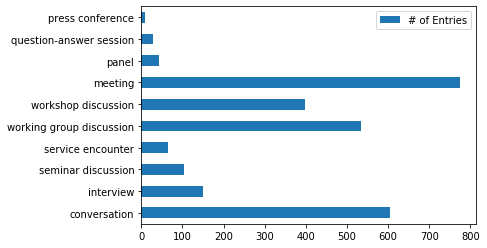

In [24]:
counts_df.plot.barh()

## Confusion Matrices on Testing Data
### 1. Multinomial Naive Bayes

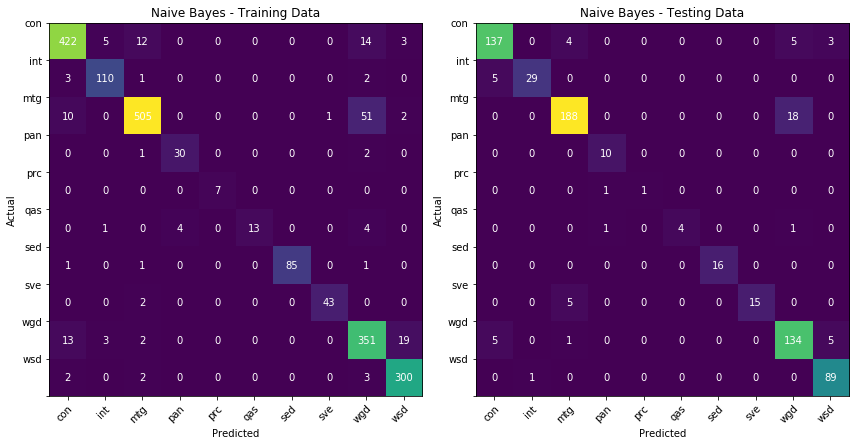

In [25]:
show_conf_matrix(wc_y_train, nb_y_train_hyp, wc_y_test, nb_y_test_hyp, "Naive Bayes")

### 2. Logistic Regression

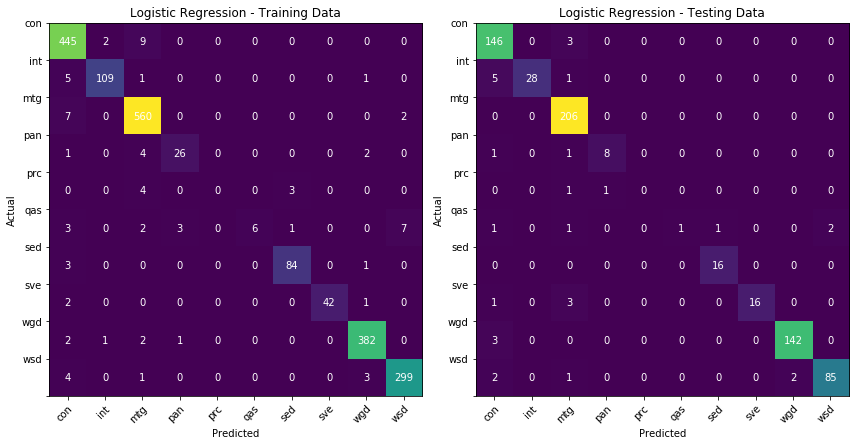

In [26]:
show_conf_matrix(tfidf_y_train, lr_train_hyp, tfidf_y_test, lr_test_hyp, "Logistic Regression")

### 3. Linear SVM

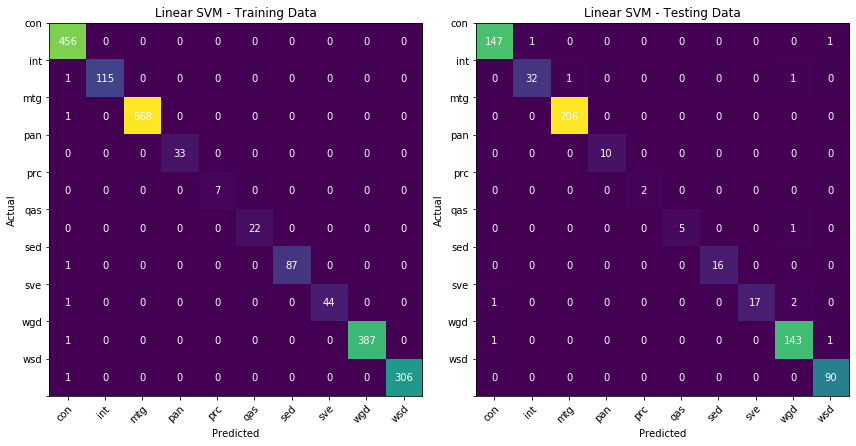

In [27]:
show_conf_matrix(tfidf_y_train, lin_svc_train_hyp, tfidf_y_test, lin_svc_test_hyp, "Linear SVM")

### 4. Sigmoid SVM

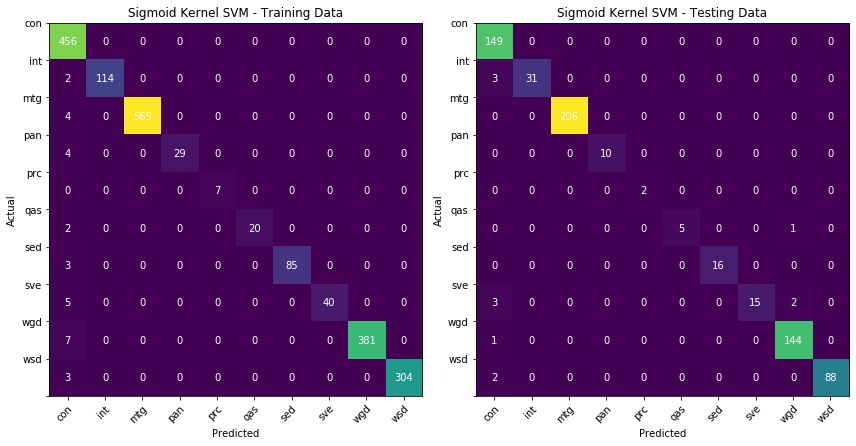

In [28]:
show_conf_matrix(tfidf_y_train, sig_svc_train_hyp, tfidf_y_test, sig_svc_test_hyp, "Sigmoid Kernel SVM")

### 5. Random Forest

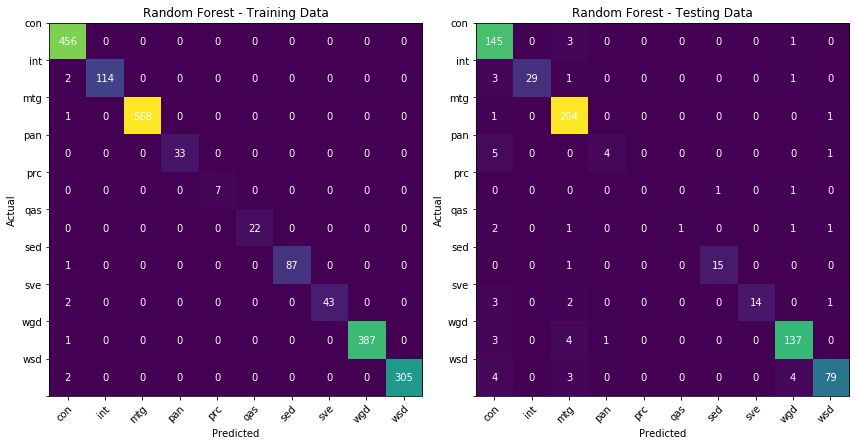

In [29]:
show_conf_matrix(tfidf_y_train, forest_train_hyp, tfidf_y_test, forest_test_hyp, "Random Forest")

### 6. AdaBoost

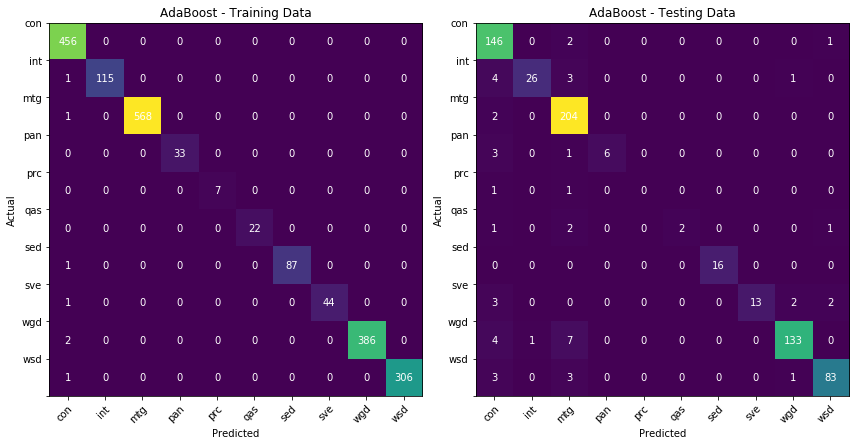

In [30]:
show_conf_matrix(tfidf_y_train, ada_train_hyp, tfidf_y_test, ada_test_hyp, "AdaBoost")

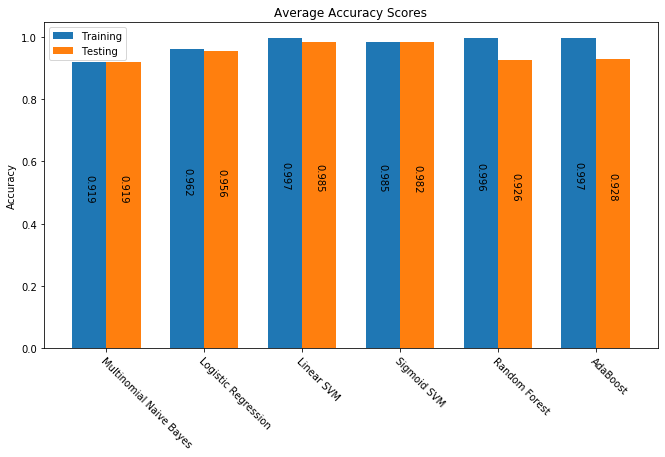

In [31]:
display_accuracy_plot()

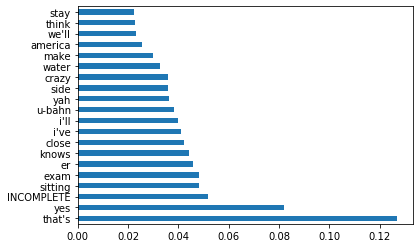

In [32]:
pd.Series(abs(lin_svc.steps[1][1].coef_[0]), index=sklearn_tfidf_df.columns).nlargest(20).plot(kind='barh')